### Geometry analysis of Acetonitrile clusters

You need the nglview and rmsd packages for this to work. 

`pip install rmsd`  
and  
https://github.com/nglviewer/nglview#installation

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import os, sys, glob, matplotlib, rmsd
import numpy as np
import nglview as nv

from ase import Atoms
from ase.io import read
from ase.visualize import view

%matplotlib notebook
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'font.size': 14})  
    
def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors


def align(atoms, ref, idx=None):
    ''' Align atoms using Kabsch '''
    if not idx:
        idx = list(range(len(atoms)))
    
    ref_pos = ref.get_positions()
    org_pos = atoms.get_positions()
    org_pos -= rmsd.centroid(org_pos[idx]) + rmsd.centroid(ref_pos[idx])

    U = rmsd.kabsch(org_pos[idx], ref_pos[idx])
    aligned = np.dot(org_pos, U.T)
    new_atoms = atoms.copy()
    new_atoms.set_positions(aligned)

    return new_atoms

def get_cm(atoms, n=3):
    ''' Get molecule centers of mass. n = atoms per mol'''
    return np.array([atoms[i:i + n].get_center_of_mass() for i in range(0, len(atoms), n)])

load structures

In [2]:
types = ['guardia', 'scme', 'pbe0mbd']
files = [sorted(glob.glob(f'structures/*{t}*')) for t in types]

structs =  []  # [read(f) for ff in files for f in ff]
for ff in files:
    structs.append([read(f) for f in ff])

Kabsch align everything to PBE0-MBD. Remove hydrogens from PBE0-MD first, but add the H mass to the C as well

In [3]:
# Remove hydrogens
no_h = [Atoms([atom for atom in atoms if atom.symbol != 'H']) for atoms in structs[-1]]
structs[-1] = no_h

# Mass of Me group, needed for Me mass we need to apply
m_me = sum(Atoms('CH3').get_masses())
corr_mass = []
for atoms in structs[-1]:
    masses = atoms.get_masses()
    masses[::3] = m_me
    atoms.set_masses(masses)
    corr_mass.append(atoms)
structs[-1] = corr_mass    

aligned = [[], []]
rmsds = np.zeros((len(structs[0]), 2))
rmsds_cm = np.zeros((len(structs[0]), 2))
for t, typ in enumerate(types[:-1]):
    for a, atoms in enumerate(structs[t]):
        atm_cmpos = get_cm(atoms)
        ref_cmpos = get_cm(structs[-1][a])
        
        atoms = align(atoms, structs[-1][a])
        atoms = align(atoms, structs[-1][a])  # look, I dunno why it needs to be done twice, ok.  But it works. 
        aligned[t].append(atoms)
        rmsds[a, t] = rmsd.rmsd(atoms.positions, structs[-1][a].positions)
        
        # Do the CM align right here
        atm_cmpos -= rmsd.centroid(atm_cmpos)
        ref_cmpos -= rmsd.centroid(ref_cmpos)
        U = rmsd.kabsch(atm_cmpos, ref_cmpos)
        atm_cmpos = np.dot(atm_cmpos, U)
        
        rmsds_cm[a, t] = rmsd.rmsd(atm_cmpos, ref_cmpos)

view(aligned[1][1] + structs[-1][1], viewer='ngl')

In [4]:
names = np.genfromtxt('structure_names.txt',dtype='str')
x = np.arange(len(rmsds))
fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
ax.bar(x - 0.2, rmsds[:, 0], color='C1', label=types[0].capitalize(), width=0.4)
ax.bar(x + 0.2, rmsds[:, 1], color='C0', label=types[1].capitalize(), width=0.4)

ax.legend(loc='best')
ax.set_ylabel('All-atom RMSD vs PBE0-MBD (Å)')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=90);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


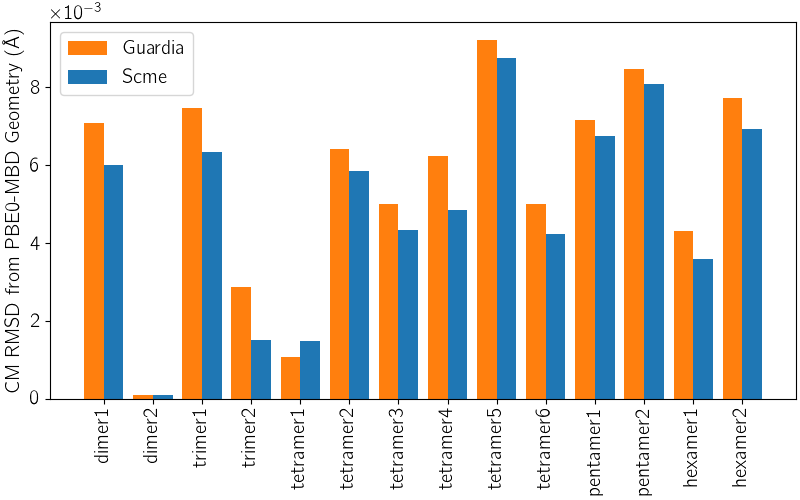

In [5]:
names = np.genfromtxt('structure_names.txt',dtype='str')
x = np.arange(len(rmsds))
fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
ax.bar(x - 0.2, rmsds_cm[:, 0], color='C1', label=types[0].capitalize(), width=0.4)
ax.bar(x + 0.2, rmsds_cm[:, 1], color='C0', label=types[1].capitalize(), width=0.4)
ax.legend(loc='best')
ax.set_ylabel('CM RMSD from PBE0-MBD Geometry (Å)')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=90);

In [6]:
v = view(structs[-1][1] + aligned[1][1], viewer='ngl')
v.children[0].add_ball_and_stick()
v

#### C-N--Me Angle Differences
This angle varies wildly depending on which type of geometry (cyclic, head-to-tail, ...) but we're only interested in the _differences_ between each FF and PBE0-MBD.

For all of the types, the sequence is Me, C, N, ... So its `get_angle(i + 1, i + 2, i + 3)` for i over molecules -1. 

You _could_ get more fancy and not just take from A->B->C, but A->B->C->A and so on... 

In [34]:
from scipy.stats import median_absolute_deviation as mad

angles = [[], [], []]
for t, typ in enumerate(types):
    for a, atoms in enumerate(structs[t]):  # Its only internal geometries, so we don't need to use the aligned
        nmol = len(atoms) // 3
        ct = 0
        for m1 in range(nmol):
            for m2 in range(m1 + 1, nmol):
                a = atoms.get_angle((m1 * 3) + 1, (m1 * 3) + 2, (m2 * 3))
                angles[t].append(a)
                ct += 1
        print(nmol, ct)
angles = np.vstack(angles).T

mad_guar = mad(angles[:, 0] - angles[:, -1]) 
mad_scme = mad(angles[:, 1] - angles[:, -1]) 

print(f'Median Absolute Deviation of Guardia-PBE0MBD: {mad_guar:4.4f} Degrees')
print(f'Median Absolute Deviation of SCME-PBE0MBD:    {mad_scme:4.4f} Degrees')

2 1
2 1
3 3
3 3
4 6
4 6
4 6
4 6
4 6
4 6
5 10
5 10
6 15
6 15
2 1
2 1
3 3
3 3
4 6
4 6
4 6
4 6
4 6
4 6
5 10
5 10
6 15
6 15
2 1
2 1
3 3
3 3
4 6
4 6
4 6
4 6
4 6
4 6
5 10
5 10
6 15
6 15
Median Absolute Deviation of Guardia-PBE0MBD: 0.1287 Degrees
Median Absolute Deviation of SCME-PBE0MBD:    0.1637 Degrees


### Combined figure 7

In [90]:
eint = np.genfromtxt('2021Aug31_1914.dat', skip_header=2)

names = np.genfromtxt('structure_names.txt',dtype='str')
x = np.arange(len(rmsds))
fig, axes = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=False)
ax = axes[0]
ax.bar(x - 0.2, rmsds_cm[:, 0], color='C1', label=types[0].capitalize(), width=0.4, edgecolor='grey')
ax.bar(x + 0.2, rmsds_cm[:, 1], color='C0', label=types[1].upper(), width=0.4, edgecolor='grey')
legend = ax.legend(loc='best')
legend.get_frame().set_alpha(.9)
bb = legend.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
yOffset = 1.5e-2
bb.y0 += yOffset
bb.y1 += yOffset
bb.x0 -= yOffset / 2
bb.x1 -= yOffset / 2
legend.set_bbox_to_anchor(bb, transform = ax.transAxes)


#legend.get_frame().set_facecolor((0, 0, 1, 0.1))
ax.set_ylabel('CM RMSD from \nPBE0-MBD Geometry (Å)')
ax.set_xticklabels([])
ax.set_xticks(x)
ax.set_yticks(np.arange(1, 10) * 1e-3)

ax = axes[1]
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=90);

ax.plot(x, eint[:, -1], 'kx-', label='PBE0-MBD')
ax.plot(x, eint[:, 1], 'C1x-', label='Guardia')
ax.plot(x, eint[:, 2], 'C0x-', label='SCME')
#ax.grid()
legend = ax.legend(loc='lower left')
legend.get_frame().set_alpha(1)
ax.set_ylabel('Interaction energy \nper monomer (eV)')
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=.01)

for ax in axes:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.5)
    ax.set_xlim([-0.75, 13.75])
fig.savefig('cluster_benchmark.pdf', bbox_inches='tight', dpi=300)
fig.savefig('cluster_benchmark.png', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>

In [77]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])